# Paper results: Fink selection of ZTF public stream supernova candidates

Supernovae are stellar explosions of interest for astrophysical and cosmology studies. They are visible during week time-scales in multiple wavelengths and potentially through other messengers such as neutrinos, gravitational waves and gamma rays. LSST is expected to discover $10^6$ supernovae during its 10 year survey ([LSST Science Collaboration et al. 2009](https://arxiv.org/pdf/0912.0201.pdf)), orders of magnitude greater than currently available data sets.

Given such data volume, the first challenge will be to disentangle different types of supernovae using the alert streams. Fink delivers classification, after only a few observations, in order to select promising candidates for further analysis and follow-up coordination using [SuperNNova](https://github.com/supernnova/SuperNNova) [(Möller & de Boissière 2019)](https://academic.oup.com/mnras/article-abstract/491/3/4277/5651173). This early identification is crucial to allow optimal distribution of follow-up efforts for further SNe studies as well as to improve training sets for photometric classifiers [(Ishida et al. 2019b)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483....2I/abstract).

This notebook reproduces the results of the Fink paper using the supernova science module. SuperNNova is a library to classify supernovae. 

### Requirements:
To run this notebook, you need to install **Apache Spark** and import the following packages:

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('talk')
from astropy.time import Time
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.coordinates import SkyCoord

# pyspark
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql.functions import pandas_udf, PandasUDFType

# fink
from fink_science.utilities import load_scikit_model, concat_col

# warnings
import warnings
warnings.filterwarnings('ignore')

You will need to create an **Spark session** to load the alerts (comment the next line if you are in a Spark cluster)

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
# useful function in the following
def get_percentage_df(num, den):
    """Print percentages for stats
    """
    return round(100 * len(num) / len(den), 2)
def get_percentage_spark(num, den):
    """Print percentages for stats
    """
    return round(100 * num.count() / den.count(), 2)

## Loading Fink data with Apache Spark

In order to accommodate the paradigm change introduced by the multi-TB alert data set of LSST, Fink is designed to take advantage of new technological approaches based on big data tools. We primarily use [Apache Spark](https://spark.apache.org/) to efficiently manipulate the data. 

Let's load processed data from November 2019 by Fink, stored on the [Zenodo DOI:10.5281](https://doi.org/10.5281/zenodo.4036589). This data has passed the quality cuts defined in the paper:

- RealBogus scores assigned by the ZTF alert distribution pipeline. The values must be above 0.55.
- Number of prior-tagged bad pixels in a 5 x 5 pixel stamp. The value must be 0.
- The difference between the aperture magnitude and the PSF-fit magnitude. The absolute value must be lower than 0.1.

In [4]:
# processed data for November and December 2019
df1 = spark.read.format('parquet').load('./year=2019/month=11')
df2 = spark.read.format('parquet').load('./year=2019/month=12')
df = df1.union(df2)

In [5]:
# Number of alerts that survived quality cuts
print('Number of alerts that pass quality cuts {}'.format(df.count()))

Number of alerts that pass quality cuts 2417284


convert to Pandas to identify SNe 

In [6]:
pdf={}
cols = ['objectId','candid','cdsxmatch','candidate.ra','candidate.dec','snn_snia_vs_nonia','snn_sn_vs_all','nalerthist']
pdf['all'] = df.select(cols).toPandas()

## Selecting relevant alerts for Supernovae

More than 2 million alerts in November and December 2019 pass the quality cuts and enter the SuperNNova module. This is too many for in-depth analysis. We need to further select relevant candidates and reduce the stream. You can do it by simply defining criteria on alert properties:

### 1. Baseline selection cuts for SNe  (no classification score yet)
As in the paper:
- Cross-match with SIMBAD: the alert must be associated with a galaxy, a candidate transient or tagged as unknown.
- Deep Learning Real Bogus score $drb>0.5$.
- At least $3$ detections in the alert package are required to promote reliable classification scores ($nalerthist$ added value from Fink).
- To filter long-term variable objects we require less than 400 detections in the ZTF survey ($ndethist$).
- To filter variable stars not present in our catalogues, we require a Star/Galaxy score by SExtractor $>0.4$.

About the SIMBAD cross-match: Supernovae are hosted in galaxies so an usual match for the alert is its host-galaxy. We include objects catalogued as transients and SN candidates as well.

In [7]:
list_SIMBAD_galaxies = [
    "galaxy",
    "Galaxy",
    "EmG",
    "Seyfert",
    "Seyfert_1",
    "Seyfert_2",
    "BlueCompG",
    "StarburstG",
    "LSB_G",
    "HII_G",
    "High_z_G",
    "GinPair",
    "GinGroup",
    "BClG",
    "GinCl",
    "PartofG",
]
keep_cds = ["Unknown", "Candidate_SN*", "SN", "Transient"] + list_SIMBAD_galaxies

In [8]:
df_selected={}
# all cuts except classification
df_selected['selectecion_cuts_only'] = df.filter(df['cdsxmatch'].isin(keep_cds))\
    .filter(df['candidate.ndethist'] < 400)\
    .filter(df['candidate.drb'] > 0.5)\
    .filter(df["candidate.classtar"] > 0.4)\
    .filter(df["nalerthist"] > 3)

# Number of alerts after cuts
print(f"selection cuts only (no classication algorithm yet) {df_selected['selectecion_cuts_only'].count()} alerts")
print(f"reduction of data stream to {get_percentage_spark(df_selected['selectecion_cuts_only'],df)} % ")
print()

selection cuts only (no classication algorithm yet) 576190 alerts
reduction of data stream to 23.84 % 



### 2. Adding classification algorithm selection
- The alert must obtain a classification score $>0.5$ (either from SN1 or SN2).

In this notebook SN1 = snn_snia_vs_nonia  and SN2 = snn_sn_vs_all

In [9]:
print_dic = {'snn_snia_vs_nonia':'SN1', 'snn_sn_vs_all':'SN2'}

#### Score >0.5

In [10]:
for class_score in print_dic.keys():
    thres = 0.5
    df_selected[f"{class_score}_gt5"] = df.filter(df[class_score] > thres)\
        .filter(df['cdsxmatch'].isin(keep_cds))\
        .filter(df['candidate.ndethist'] < 400)\
        .filter(df['candidate.drb'] > 0.5)\
        .filter(df["candidate.classtar"] > 0.4)\
        .filter(df["nalerthist"] > 3)

    # Number of alerts after cuts
    print(f"{print_dic[class_score]} > {thres} {df_selected[f'{class_score}_gt5'].count()} alerts")
    print(f"reduction of data stream to {get_percentage_spark(df_selected[f'{class_score}_gt5'], df)}")
    print()

SN1 > 0.5 365228 alerts
reduction of data stream to 15.11

SN2 > 0.5 208978 alerts
reduction of data stream to 8.65



#### Score >0.6

In [11]:
# now with classification scores
for class_score in print_dic.keys():
    thres = 0.6
    df_selected[f"{class_score}_gt6"] = df.filter(df[class_score] > thres)\
        .filter(df['cdsxmatch'].isin(keep_cds))\
        .filter(df['candidate.ndethist'] < 400)\
        .filter(df['candidate.drb'] > 0.5)\
        .filter(df["candidate.classtar"] > 0.4)\
        .filter(df["nalerthist"] > 3)

    # Number of alerts after cuts
    print(f"{print_dic[class_score]} > {thres} {df_selected[f'{class_score}_gt6'].count()} alerts")
    print(f"reduction of data stream to {get_percentage_spark(df_selected[f'{class_score}_gt6'], df)}")
    print()

SN1 > 0.6 308822 alerts
reduction of data stream to 12.78

SN2 > 0.6 145736 alerts
reduction of data stream to 6.03



###  Unique objects
The main dataset of Fink is made of individual alerts. But many alerts can come from the same object on the sky (e.g. variable stars or SN typically emit several alerts over weeks). You can simply count the number of unique object by grouping by `objectId`

In [12]:
# unique objectId
for class_score in df_selected.keys():
    print(class_score, df_selected[class_score].groupBy('objectId').count().count())

selectecion_cuts_only 184722
snn_snia_vs_nonia_gt5 133672
snn_sn_vs_all_gt5 89405
snn_snia_vs_nonia_gt6 114799
snn_sn_vs_all_gt6 68764


convert to Pandas to manipulate

In [13]:
cols = ['objectId','candid','cdsxmatch','candidate.ra','candidate.dec','snn_snia_vs_nonia','snn_sn_vs_all','nalerthist']
for class_score in df_selected.keys():
    pdf[class_score] = df_selected[class_score].select(cols).toPandas()

## Matching with TNS data

The [Transient Name Server (TNS)](https://wis-tns.weizmann.ac.il) is the official IAU mechanism for reporting new astronomical transients and it contains many supernova (candidates and confirmed). Once spectroscopically confirmed, new supernova discoveries are officially designated a SN name. We retrieve confirmed SNe in 2019 from TNS, and match the coordinates to transients detected by ZTF.

In [14]:
# Load all TNS files available
dic_tag_idxs = {}
# load tags known, e.g.g TNS
pdf_TNS_SNe = pd.read_csv("./TNS_SNe_Oct_Dec_paper.csv")
pdf_TNS_SNe = pdf_TNS_SNe.drop_duplicates()

pdf_TNS_SNeIa = pdf_TNS_SNe[pdf_TNS_SNe["Obj. Type"] == "SN Ia"]
print("SNeIa",len(pdf_TNS_SNeIa))
print("SNe",len(pdf_TNS_SNe))

SNeIa 613
SNe 702


We identify those SNe discovered from November on 2019.

In [15]:
idx_discovered_gt_November = pdf_TNS_SNe[pdf_TNS_SNe['Discovery Date (UT)']>= '2019-11-01'].objectId.unique().tolist()

# ZTF alerts and TNS stats 
## 1. Cross-match by coordinates

Beware! We use astropy match_to_catalogue_sky which provides the closest neighbour to a coordinate. There may be multiple alerts with the same coordinate as this is not real time processing, so we need to deal with this.

In [16]:
# ZTF
obj1, ra1, dec1 = pdf['all'].objectId.to_numpy(), pdf['all'].ra.to_numpy(), pdf['all'].dec.to_numpy()
# TNS
obj2, ra2, dec2 = pdf_TNS_SNe.objectId.to_numpy(), pdf_TNS_SNe.RA.to_numpy(), pdf_TNS_SNe.DEC.to_numpy()

In [17]:
# create catalogs
catalog_ztf = SkyCoord(ra=np.array(ra1, dtype=np.float)*u.degree, dec=np.array(dec1, dtype=np.float)*u.degree)
catalog_tns = SkyCoord(ra=np.array(ra2, dtype=str), dec=np.array(dec2, dtype=str), unit=(u.hour, u.deg), frame='icrs')

In [18]:
# cross-match
idx, d2d, d3d = catalog_ztf.match_to_catalog_sky(catalog_tns)

In [19]:
# save it in a data frame
associations = pd.DataFrame()
associations['objectId'] = pdf['all'].objectId
associations['assoc_SNe'] = pdf_TNS_SNe.iloc[idx]['objectId'].values
associations['assoc_SNe_d'] = d2d
associations['assoc_SNe_type'] = pdf_TNS_SNe.iloc[idx]['Obj. Type'].values
# set separation length
associations = associations[associations['assoc_SNe_d']<(1.5*u.arcsec).to(u.deg)]
associations = associations.drop_duplicates()

In [20]:
# Some stats on these matches
print(f"Number of SNe in the alert stream passing quality cuts {len(associations.objectId.unique())}")
print(f"Number of SNeIa in the alert stream passing quality cuts {len(associations[associations['assoc_SNe_type']=='SN Ia'].objectId.unique())}")

Number of SNe in the alert stream passing quality cuts 366
Number of SNeIa in the alert stream passing quality cuts 296


In [21]:
# Some stats on these matches
for k in pdf.keys():
    if 'assoc_SNe_type' not in pdf[k].keys():
        pdf[k] = pd.merge(pdf[k],associations, on = 'objectId',how='left')
        print(f"{k} SNeIa: {len(pdf[k][pdf[k]['assoc_SNe_type']=='SN Ia'].objectId.unique())} SNe: {len(pdf[k][~pdf[k]['assoc_SNe'].isna()].objectId.unique())}")

all SNeIa: 296 SNe: 366
selectecion_cuts_only SNeIa: 258 SNe: 319
snn_snia_vs_nonia_gt5 SNeIa: 242 SNe: 296
snn_sn_vs_all_gt5 SNeIa: 223 SNe: 275
snn_snia_vs_nonia_gt6 SNeIa: 229 SNe: 278
snn_sn_vs_all_gt6 SNeIa: 196 SNe: 245


# Time delay between classification and SN Ia peak
An important metric is the time of 1st classification by Fink, compared to the SN Ia peak. Ideally, we want to catch the supernova before the flux peak to allow efficient follow-up. Let's compute the time delay in the case of Fink, using the current SNN module:

In [22]:
@pandas_udf("double", PandasUDFType.GROUPED_AGG)
def peakdelay(mag, jd, cmag, cjd):
    """ Very rough estimate of the delay between first
    classification date by Fink and the SN Ia peak.
    
    The search is done on the measurements (no fit).
    """
    index = np.where(mag == np.min(mag))[0][0]
    jd0 = np.min(jd)
    
    # peak is prior the detection - look at the history
    if np.min(jd) - jd.values[index] == 0:
        # Search for the history of the 1st alert
        min_jds = np.array([np.min(jd_) for jd_ in cjd])
        index = np.where(min_jds == np.min(min_jds))[0][0]
        
        # inplace replacement
        mag = np.array(cmag[index])
        jd = np.array(cjd[index])
        
        # remove upper limits
        mask = mag == mag
        
        # True SN peak!
        if len(mag[mask]) <= 1:
            return 0
        
        # search for the min mag
        index = np.where(mag[mask] == np.min(mag[mask]))[0][0]
        
        # Not enough points in the rising part
        if index < 3:
            return None
        
        # Not reached the peak yet
        if index > len(mag[mask]) - 2:
            return None

        return jd0 - jd[mask][index]
    else:
        return jd0 - jd.values[index]



In [23]:
# Look at the. delay only if it was discovered from Nobvember on
# to avoid light-curves that were discovered e.g. in October that we only see their tail
df_snia = df_selected["snn_snia_vs_nonia_gt5"].filter(df_selected["snn_snia_vs_nonia_gt5"]['objectId'].isin(idx_discovered_gt_November))
df_snia = concat_col(df_snia, 'magpsf', prefix='c')
df_snia = concat_col(df_snia, 'jd', prefix='c')

catalog_matches = pdf["snn_snia_vs_nonia_gt5"][pdf["snn_snia_vs_nonia_gt5"]['assoc_SNe_type']=='SN Ia'].objectId.unique()

df_peak = df_snia.filter(df_snia['objectId'].isin(catalog_matches.tolist()))\
    .groupBy('objectId')\
    .agg(peakdelay(df_snia['candidate.magpsf'], df_snia['candidate.jd'], df_snia['cmagpsf'], df_snia['cjd']).alias('peakdelay'))

df_peak.show(10)

pdf_peak = df_peak.toPandas()

+------------+--------------------+
|    objectId|           peakdelay|
+------------+--------------------+
|ZTF19acruqph| -11.959097200073302|
|ZTF19aculypc|-0.03579859994351864|
|ZTF19acykjcw|-0.01135420007631...|
|ZTF19acmdpyr| -13.000069399829954|
|ZTF19acxyucu|  13.002476800233126|
|ZTF19acygjmg|                null|
|ZTF19acxowwt|  12.948738400358707|
|ZTF19acyogvo|  -9.911134299822152|
|ZTF19acspfcb|                null|
|ZTF19acokzjy|  -6.002198999747634|
+------------+--------------------+
only showing top 10 rows



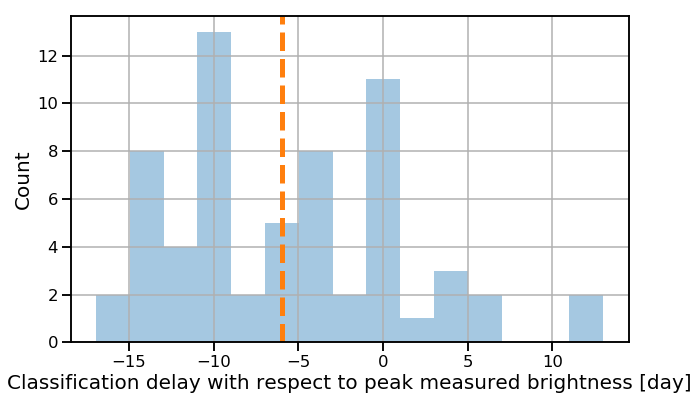

In [24]:
font = {
        'weight': 'normal',
        'size': 20,
        }
fig = plt.figure(figsize=(10, 6))
sns.distplot(pdf_peak[~pdf_peak.peakdelay.isna()].peakdelay, bins=15, kde=False)
plt.xlabel('Classification delay with respect to peak measured brightness [day]',fontdict=font)
plt.ylabel('Count',fontdict=font)
plt.grid()

mask = pdf_peak.peakdelay == pdf_peak.peakdelay
plt.axvline(np.median(pdf_peak.peakdelay[mask]), ls='--', color='C1', lw=5)
plt.show()

# plt.savefig('snia_delay_pastnov_haspeak.png')

In [25]:
print(f"Median delay {round(np.median(pdf_peak.peakdelay[mask]),2)}")

Median delay -5.96
